<a href="https://colab.research.google.com/github/MoltenMuffins/HipsterNotHipster/blob/master/HipsterNotHipster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HipsterNotHipster

### Problem Statement
This project attempts to create one class image classifier via transfer learning on top of VGG-Face as a final project submission for the December iteration of the Deep Learning Jump Start Workshop conducted by Red Dragon AI. The dataset used is self generated using a bulk image downloading tool (fatkun) while the VGG-Face weights for tensorflow are kindly provided by Sefik at https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/. 

While the choice of topic "Hipster vs Not Hipster" seems rather whimsical, my intention with the project was to try to captilize on the ability of neural networks to generate features independently and see if it can replicate subjective human categorization.

After training the model by running the code in the notebook, you can also try out the classification model on yourself in the "[Are You a Hipster?](#scrollTo=xJ34ZlbZD9eM)" section where you can take an image with your webcam to feed it into the classification model.

### Possible Issues and Actions Taken
*   The prevalence of beards in contemporary hipster culture leads to many of the 'hipster' positive examples showing beards. My attempt to mitigate this involves including sufficient examples of non-hipsters with beards (eg. muslim men). 
*   Confirmation bias is also present as the training examples are created by me and hence the classifier would be directly affect by my own perceptions of what constitutes a hipster. The accuracy of the model in use thus varies from person to person.
*  I did not have a rubric for classifying hipsters and allocated labels to images solely based on my own gut feeling which could cause inconsistency in the labeling.
* Due to my fixation on beards, I neglected to include examples of the female gender in this run of the project. A third iteration of this project would include the female gender, or better yet include a spectrum of genders.

### Summary of Results
My initial hypothesis would be that the imagenet model with weights would perform favorably as I felt the clothes and accessories on the person would be a key component of identifying a hipster. An earlier iteration of this project involved using the standard VGG-16 model with imagenet weights, and produced results around *~0.50*.

My second approach is contained in this notebook. It uses the VGGface model which essentially is a VGG model trained on celebrity faces. The process of implementing this model took longer (mainly due to time spent trying to understand the VGGface topology and finding a source for VGGface weights as the relevant github repo has outdated code that can't be run) but produces slightly better results of *~0.67*. 

This current build seems to work well and suggests that whether one is a hipster has more to do with one's facial features and hair rather than their dressing. I expect that this model could exhibit improvements in performance if given a larger dataset. For a third iteration, a larger dataset would definitely be required. In order to increase the efficiency of labeling, I might look into builing an application or tool modeled after tinder where one could simply swipe left or right to label images. This would greatly speed up the dataset creation process for this project and any other future endeavors.


## 0. Testing for GPU

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# Download VGGface weights. These are orignially weights for caffe and converted to 
# keras and obtained from https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
!wget -qq https://www.dropbox.com/s/lhmr5sa6lcr0f23/vgg_face_weights.h5

In [3]:
#Boilerplate code
import os, json
from glob import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

import tensorflow as tf

tf.VERSION

'1.13.1'

##  1. Dataset Download and Organization

We use a small dataset that I prepared using FatKun which has been pre-labeled. 

It has the following file structure: 
`Data/hipsternothipster/{CLASS_LABEL}/{FILENAME}.jpg`

In [4]:
#Download dataset

!wget -qq https://www.dropbox.com/s/cqy2r8xmnqfoh5n/data.zip
!unzip -qq data.zip
!rm data.zip
!rm -r __MACOSX
!ls

data  sample_data  vgg_face_weights.h5


## 2. Preparing Dataset for our model



We use glob to get lists of the files in the directories and then convert them into dataframes and add in class numbers.

We also then split them up so we have 10% for a testing set and the rest for training.

Finally we randomly shuffle them up


In [0]:
path = "./data/hipsternothipster/"

In [0]:
train_data_dir = "./data/hipsternothipster/train/"
validation_data_dir = "./data/hipsternothipster/valid/"

In [7]:
import glob
import pandas as pd

filenames_n0 = glob.glob('./data/hipsternothipster/train/nothipster/*.jpg')
filenames_n1 = glob.glob('./data/hipsternothipster/train/hipster/*.jpg')


names = ['nothipster', 'hipster']


len(filenames_n1)

186

In [0]:
# Make a dataframe based on the filenames
df = pd.DataFrame(filenames_n0, columns = ["filename"])
df2 = pd.DataFrame(filenames_n1, columns = ["filename"])


# Add Class columns 
df['class'] = pd.Series([0 for x in range(len(df.index))], index=df.index)
df2['class'] = pd.Series([1 for x in range(len(df2.index))], index=df2.index)



# Split into train and validation sets
train_set_percentage = .9


train_df = df[:int(len(df)*train_set_percentage)]
val_df = df[int(len(df)*train_set_percentage):]

train_df2 = df2[:int(len(df2)*train_set_percentage)]
val_df2 = df2[int(len(df2)*train_set_percentage):]


df_new_train = pd.concat([train_df, train_df2])
df_new_val = pd.concat([val_df, val_df2])

# shuffle 
df = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)

In [9]:
df.head()

,filename,class
0,./data/hipsternothipster/train/hipster/hipster...,1
1,./data/hipsternothipster/train/hipster/hipster...,1
2,./data/hipsternothipster/train/nothipster/noth...,0
3,./data/hipsternothipster/train/hipster/hipster...,1
4,./data/hipsternothipster/train/hipster/hipster...,1


In [10]:
# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df["filename"].tolist()
train_labels_list = df["class"].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val["filename"].tolist()
val_labels_list = df_val["class"].astype('int32').tolist()

#number of classes
num_classes = 2

df.shape

(328, 2)

In [11]:
train_filenames_list[:5]

['./data/hipsternothipster/train/hipster/hipster.162.jpg',
 './data/hipsternothipster/train/hipster/hipster.069.jpg',
 './data/hipsternothipster/train/nothipster/nothipster.080.jpg',
 './data/hipsternothipster/train/hipster/hipster.147.jpg',
 './data/hipsternothipster/train/hipster/hipster.186.jpg']

## 3. Make the pipeline for loading and resizing the images


In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 224,224

def _parse_function(filename, label):
  image_string = tf.read_file(filename)
  #Channels specified to be 3 to ensure images output as [224,224,3] at the end of this
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  image_resized = tf.image.resize_images(image_decoded, [img_rows, img_cols])
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [0]:
# Create vector of filenames from list
filenames = tf.constant(train_filenames_list)

# Create vector of labels
labels = tf.constant(train_labels_list)

# Same as above but for validation set
val_filenames = tf.constant(val_filenames_list)
val_labels = tf.constant(val_labels_list)

## 4. Assembling the Data pipeline using tf.data


In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(32)

valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(32)

## 5. Loading Trained Model Weights

We utilize a pretrained model, VGGface, for which we intend to utilize Transfer Learning on. This allows us to leverage on the compute put into the pretrained model, reducing the need for training on our end.

In [15]:
from tensorflow import keras
from keras.models import model_from_json

Using TensorFlow backend.


In [16]:
#VGG-Face model is slightly different from VGG-16. Fortunately, the blogger who provided the weights
#Earlier also transcribed the model for us link -> https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
base_model = Sequential()

base_model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
base_model.add(Convolution2D(64, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(64, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(128, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(128, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(256, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(256, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(256, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(512, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(512, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(512, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(512, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(512, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(512, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
base_model.add(Convolution2D(4096, (7, 7), activation='relu'))
base_model.add(Dropout(0.5))
base_model.add(Convolution2D(4096, (1, 1), activation='relu'))
base_model.add(Dropout(0.5))
base_model.add(Convolution2D(2622, (1, 1)))
base_model.add(Flatten())
base_model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
#Loading the weights
base_model.load_weights('vgg_face_weights.h5')

In [0]:
# The rest is standard transfer learning

# Here we add a global spatial average pooling layer
x = base_model.output

x = Flatten()(x)

# Add a fully-connected layer
x = Dense(512, activation='relu')(x)

# Add logits layer for 2 classes
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [19]:
# Train only the top layers which were randomly initalized and freeze all convolutional VGG16 layers
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False

zero_padding2d
conv2d
zero_padding2d_1
conv2d_1
max_pooling2d
zero_padding2d_2
conv2d_2
zero_padding2d_3
conv2d_3
max_pooling2d_1
zero_padding2d_4
conv2d_4
zero_padding2d_5
conv2d_5
zero_padding2d_6
conv2d_6
max_pooling2d_2
zero_padding2d_7
conv2d_7
zero_padding2d_8
conv2d_8
zero_padding2d_9
conv2d_9
max_pooling2d_3
zero_padding2d_10
conv2d_10
zero_padding2d_11
conv2d_11
zero_padding2d_12
conv2d_12
max_pooling2d_4
conv2d_13
dropout
conv2d_14
dropout_1
conv2d_15
flatten
activation


In [20]:
model.summary()
#incoming wall of text, brace yourself

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_input (InputL (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
__________

## 6. Training Top Layers on Dataset

In [0]:
opt = tf.train.AdamOptimizer(learning_rate = 0.001)

# We can now compile the model now that layers have been set to non trainable
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
#Set Hyperparams
train_steps = 200
val_steps = 50
epochs = 1

In [23]:
# Train the model with validation, shouldn't take too long because of puny dataset
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Instructions for updating:
Use tf.cast instead.
200/200 [==============================] - 178s 890ms/step - loss: 0.5924 - acc: 0.6783 - val_loss: 0.7507 - val_acc: 0.5681


In [24]:
metrics = model.evaluate(valid_dataset,
                   steps = val_steps)
print("model accuracy:",metrics[1])

50/50 [==============================] - 40s 795ms/step - loss: 0.7507 - acc: 0.5681
model accuracy: 0.568125


## 7. Adhoc Testing on Single Images

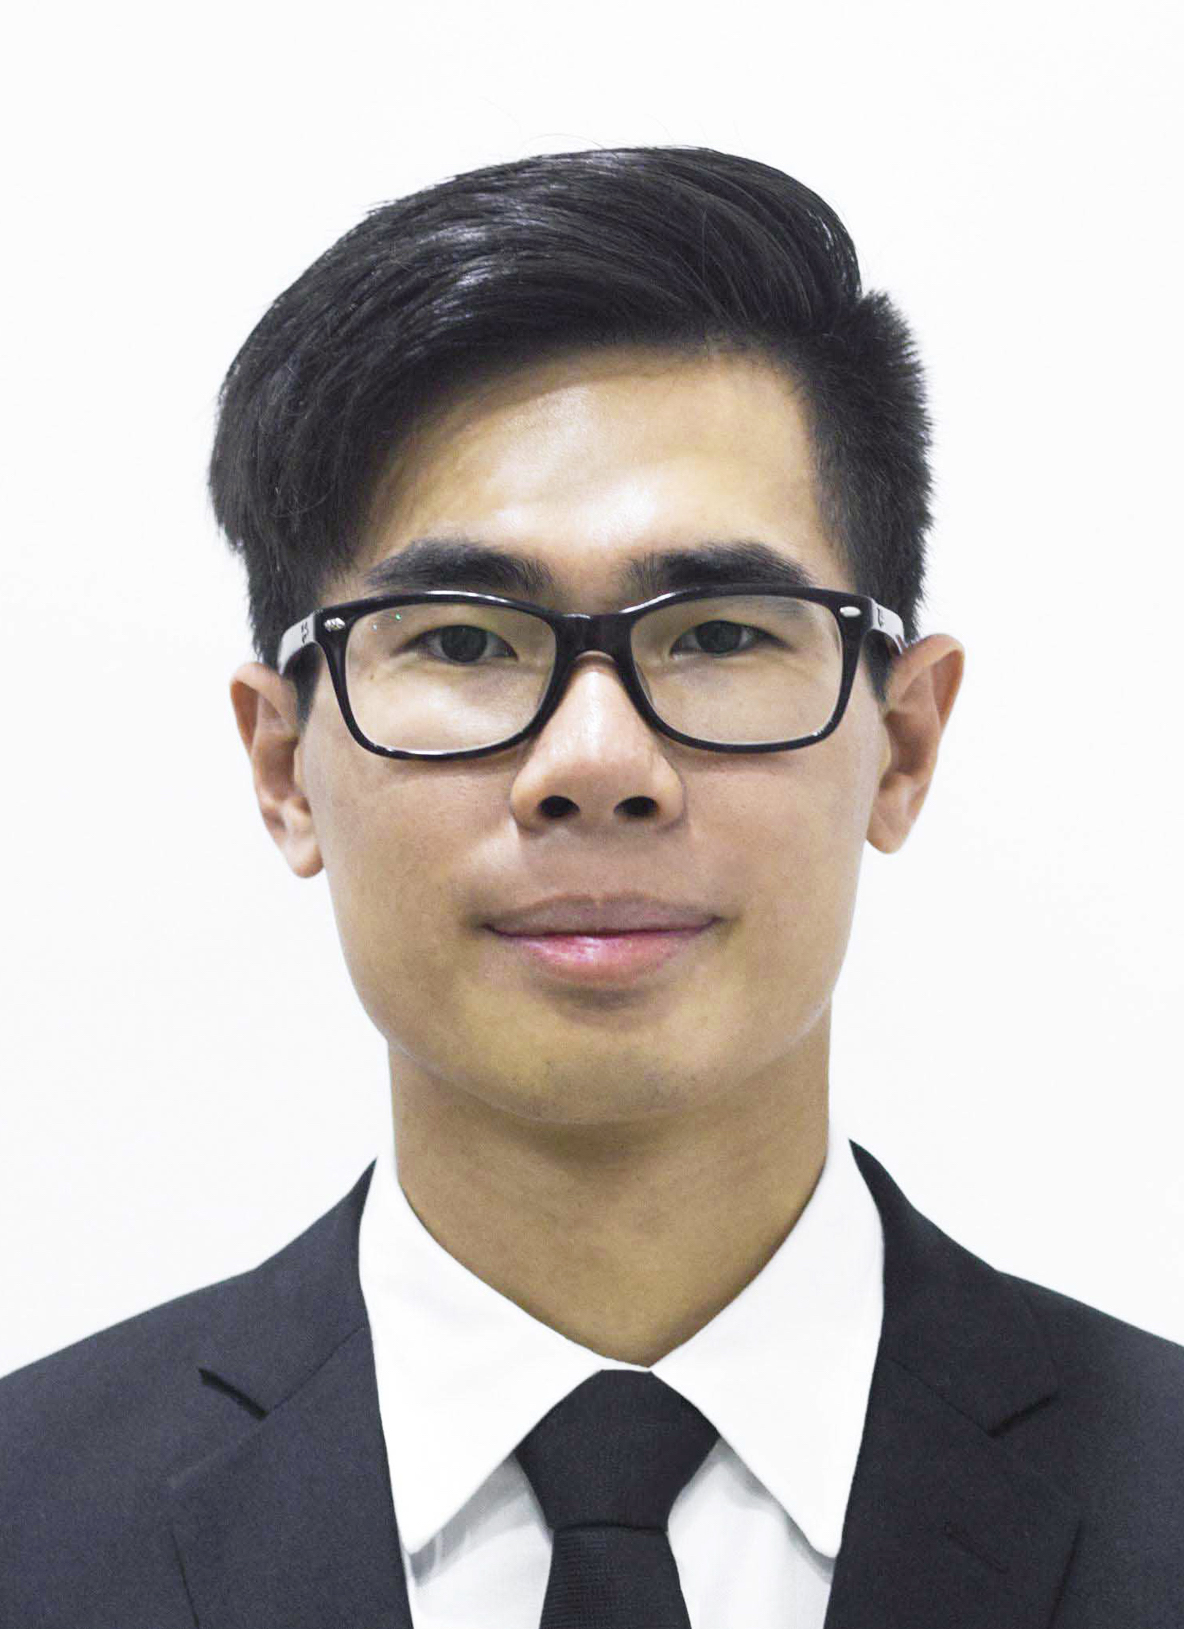

In [33]:
image_path = './data/hipsternothipster/test/'

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np
from IPython.display import Image

#You may replace 1000.jpg with the following [1001.jpg, 1002.jpg, 2000.jpg, 3000.jpg, 4000.jpg] or your own uploaded image
#For convenience, upload the image into the "test" folder to avoid having to change the image path
image_check = '1000.jpg'

Image(image_path+image_check, width=224, height=300)


In [26]:
img_path = os.path.join(image_path, image_check)
print(img_path)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

preds = model.predict(x)
print('Predicted:', preds)

result = preds[0][0]
if result < preds[0][1]:
    print("Hipster")
else:
    print("Not Hipster")

./data/hipsternothipster/test/1000.jpg
Input image shape: (1, 224, 224, 3)
Predicted: [[0.34028822 0.65971184]]
Hipster


It seems the model is able to differentiate between hipsters, at least according to my own perception of what a hipster is.

# Are You a Hipster?

After running the code above, the HipsterNotHipster classifier should have been trained and shown to work (relatively). 

Try out the classifier on yourself by running the code block below! 

(Webcam access required. Best results when only one face is within the image frame.)

In [49]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode

VIDEO_HTML = """
<video autoplay
 width=300 height=224></video>
<script>
var video = document.querySelector('video')
navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo(filename='selfie.jpg', quality=0.8):
  display(HTML(VIDEO_HTML % quality))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return len(binary)

print('Click on the webcam feed in order to take a photo!')
take_photo()

img = image.load_img('./selfie.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Probability of not being a hipster: {} \nProbability of being a hipster: {}'.format(preds[0][0], preds[0][1]))
      
result = preds[0][0]
if result< preds[0][1]:
    print("Conclusion: You are most likely a Hipster!")
else:
    print("Conclusion: You are most likely Not a Hipster!")

Click on the webcam feed in order to take a photo!


Probability of being a hipster: 0.6143965721130371 
Probability of not being a hipster: 0.3856034576892853
Conclusion: You are most likely a Hipster!
